In [1]:
import os
import tomllib
from functools import partial
from pprint import pprint
from random import randint

import matplotlib.pyplot as plt
import PIL
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from util import *

In [2]:
with open('parameters.toml', 'r') as f:
    parameters = tomllib.loads(f.read())
    
pprint(parameters)

{'TRAINING': {'batch_size': 32,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'num_epochs': 10,
              'num_workers': 4,
              'pin_memory': True,
              'precision_threshold': 0.9,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
training_ratio = parameters['TRAINING']['training_dataset_ratio']
testing_ratio = round(1 - training_ratio, 1)

print(f'Training ratio: {training_ratio*100}%')
print(f'Testing ratio: {testing_ratio*100}%')

seed = randint(0, 1000)
print(f'\nSeed: {seed}')


Training ratio: 80.0%
Testing ratio: 20.0%

Seed: 705


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

criterion = nn.BCELoss().to(device)

loader_kwargs = {'batch_size': parameters['TRAINING']['batch_size'], 'shuffle': parameters['TRAINING']['shuffle'], 'num_workers': parameters['TRAINING']['num_workers'], 'pin_memory': parameters['TRAINING']['pin_memory']}

base_dataset = SkinDiseaseDataset(root_dir='dataset', transform=transform)
train_dataset, test_dataset = split_datasets(base_dataset, training_ratio, testing_ratio, seed)

train_loader = DataLoader(train_dataset, **loader_kwargs)
test_loader = DataLoader(test_dataset, **loader_kwargs)

train_cnn = partial(train_model, criterion=criterion, device=device, verbose=False)

print(f'Total dataset: {len(base_dataset)} items.\n')
print(f'Training: {len(train_dataset)} items.')
print(f'Testing: {len(test_dataset)} items.')

Total dataset: 11039 items.

Training: 8831 items.
Testing: 2207 items.


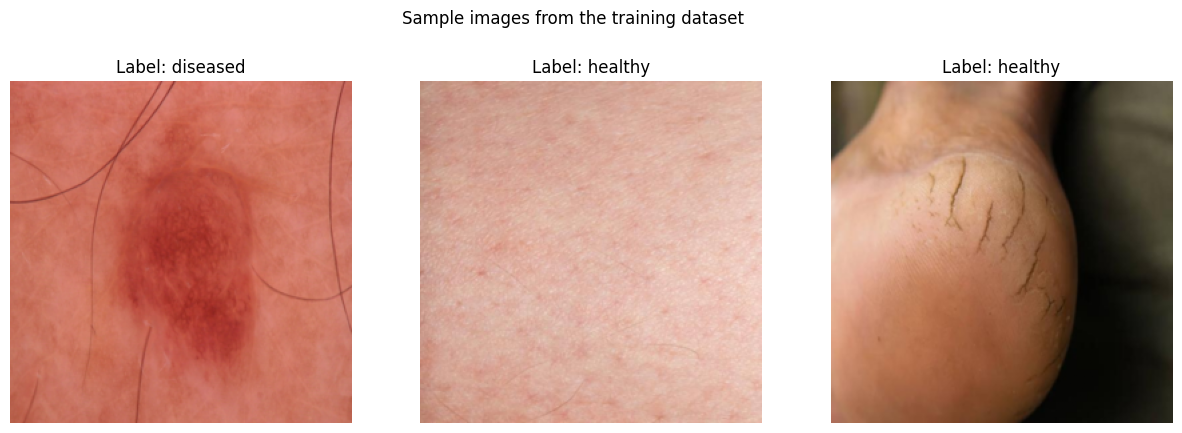

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Sample images from the training dataset')

for i, (image, label) in enumerate(train_loader):
    ax[i].imshow(image[0].permute(1, 2, 0))
    ax[i].set_title(f'Label: {"diseased" if label[0] else "healthy"}')
    ax[i].axis('off')

    if i == 2:
        break

plt.show()

## Model 1: Images with no pre-processing

In [7]:
model = BinaryCNN().to(device)
optimizer = optim.Adam(model.parameters())

train_cnn(model=model, optimizer=optimizer, data_loader=train_loader)

KeyboardInterrupt: 